# Task04 建模調參

## Task04 目標及內容
### 目標
>掌握常用機器學習建模及調參流程

### 內容
>1. 模型：線性回歸、決策樹、及比賽常用隨機森林、GBDT、XGBoost、LightGBM 模型  
2. 模型結果對比、調參

## O、Task03 數據預處理
### 缺失異常處理
>1. 剔除訓練集中model缺失的1筆數據  
2. bodyType, fuelType, gearbox 以眾數補全  
    (以訓練集眾數補全，但依據訓練及測試集數據分布來看，兩者分布基本相同故眾數應相同)  
3. notRepairedDamage：'-'部分需替換為空值，並將整個字段轉為float形式；空值視為第三類別=2  
4. power：剔除>600部分；訓練集 power==0部分視為缺失，並用訓練集 power 以 bodyType 分組後各組中位數來補全  

### 特徵構造
>1. "age" = createDate年份 - regDate年份  
2. "age_bin" = "age"每五年分一箱  
3. "power"每50分一箱(max=250)
4. price在各brand的統計量 
5. price在各bodyType的統計量

**需特別注意有些預處理只適用於訓練集**

In [2]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
"""讀取數據"""
train = pd.read_csv('./raw_data/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('./raw_data/used_car_testA_20200313.csv', sep=' ')

"""concat 訓練及測試集，並增加字段train來表示是否為訓練集數據"""
train['train'] = 1
test['train'] = 0
all_data = pd.concat([train,test],ignore_index=True)

In [3]:
"""import 自己寫的預處理函數腳本 """
from preprocessing import preprocessing_functions

In [4]:
"""缺失異常處理"""

### 1. 剔除訓練集中 model 缺失的 1 筆數據 (測試集中並無缺失，故這邊省略是否為訓練集的判定)
all_data.dropna(subset=['model'],inplace=True)

### 2. bodyType, fuelType, gearbox 以眾數補全
all_data['bodyType'] = preprocessing_functions.fillna_with_mode_of_train(all_data,'bodyType')
all_data['fuelType'] = preprocessing_functions.fillna_with_mode_of_train(all_data,'fuelType')
all_data['gearbox'] = preprocessing_functions.fillna_with_mode_of_train(all_data,'gearbox')

### 3. notRepairedDamage：'-'部分需替換為空值，並將整個字段轉為float形式；空值視為第三類別 =2
all_data['notRepairedDamage'] = preprocessing_functions.null_str_to_null_float(all_data,'notRepairedDamage')
all_data['notRepairedDamage'].fillna(2,inplace=True)

### 4. power：剔除訓練集>600部分；訓練集 power==0部分視為缺失，並用訓練集 power 以 bodyType 分組後各組中位數來補全
all_data = all_data[(all_data.power<=600) | ((all_data.power>600)&(all_data.train==0)) ]
all_data.power.replace(0,np.nan,inplace=True)
all_data['power'] = preprocessing_functions.fillna_with_grouped_train_median(all_data,'bodyType','power')

In [5]:
"""特徵構造"""

### 1. "age" = createDate年份 - regDate年份
all_data['age'] = preprocessing_functions.cal_car_age(all_data)

### 2. "age_bin" = "age"每五年分一箱
all_data['age_bin'] = preprocessing_functions.sep_bins(all_data, 'age', 5)

### 3. "power" 每 50分一箱 (且因長尾關係，另外設定>250都分一箱)
all_data['power_bin'] = preprocessing_functions.sep_bins(all_data, 'power', 50, max_=250)

### 4. price在各brand的統計量
all_data = preprocessing_functions.cal_grouped_stats(all_data,'brand','price')

### 5. price在各bodyType的統計量
all_data = preprocessing_functions.cal_grouped_stats(all_data,'bodyType','price')

In [6]:
print('所有特徵:')
all_data.columns

所有特徵:


Index(['SaleID', 'bodyType', 'brand', 'creatDate', 'fuelType', 'gearbox',
       'kilometer', 'model', 'name', 'notRepairedDamage', 'offerType', 'power',
       'price', 'regDate', 'regionCode', 'seller', 'train', 'v_0', 'v_1',
       'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5',
       'v_6', 'v_7', 'v_8', 'v_9', 'age', 'age_bin', 'power_bin',
       'brand_gp_price_median', 'brand_gp_price_mean', 'brand_gp_price_size',
       'brand_gp_price_std', 'brand_gp_price_max', 'brand_gp_price_min',
       'bodyType_gp_price_median', 'bodyType_gp_price_mean',
       'bodyType_gp_price_size', 'bodyType_gp_price_std',
       'bodyType_gp_price_max', 'bodyType_gp_price_min'],
      dtype='object')

In [7]:
all_data.head()

,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,regDate,regionCode,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,age,age_bin,power_bin,brand_gp_price_median,brand_gp_price_mean,brand_gp_price_size,brand_gp_price_std,brand_gp_price_max,brand_gp_price_min,bodyType_gp_price_median,bodyType_gp_price_mean,bodyType_gp_price_size,bodyType_gp_price_std,bodyType_gp_price_max,bodyType_gp_price_min
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,0,60.0,1850.0,20040402,1046,0,1,43.357796,3.966344,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,12,3.0,2.0,1800.0,3607.928375,10206,4650.025544,40950.0,13.0,1600.0,2790.191765,35241,3159.663046,99999.0,12.0
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,2.0,0,140.0,3600.0,20030301,4366,0,1,45.305273,5.236112,-4.900482,2.096338,-1.030483,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,13,3.0,3.0,6499.0,9272.585414,13780,9363.917624,99900.0,15.0,3500.0,5820.259655,30294,6320.798831,69900.0,15.0
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,0,163.0,6222.0,20040403,2806,0,1,45.978359,4.823792,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,12,3.0,4.0,8500.0,9858.582990,1458,5425.058140,45000.0,100.0,1600.0,2790.191765,35241,3159.663046,99999.0,12.0
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,0,193.0,2400.0,19960908,434,0,1,45.687478,4.492574,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,20,5.0,4.0,5400.0,8449.322819,14234,8916.556379,98000.0,15.0,3000.0,5684.936548,45877,6884.557748,99999.0,11.0
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,0,68.0,5200.0,20120103,6977,0,1,44.383511,2.031433,-1.896240,0.910783,0.931110,2.834518,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,4,1.0,2.0,2300.0,3306.375375,4662,3344.689763,31500.0,20.0,1600.0,2790.191765,35241,3159.663046,99999.0,12.0


In [8]:
### 再次確認是否有缺失
all_data.isnull().sum() 
### > price缺失部分為測試集，其他字段都沒有缺失

SaleID                          0
bodyType                        0
brand                           0
creatDate                       0
fuelType                        0
gearbox                         0
kilometer                       0
model                           0
name                            0
notRepairedDamage               0
offerType                       0
power                           0
price                       50000
regDate                         0
regionCode                      0
seller                          0
train                           0
v_0                             0
v_1                             0
v_10                            0
v_11                            0
v_12                            0
v_13                            0
v_14                            0
v_2                             0
v_3                             0
v_4                             0
v_5                             0
v_6                             0
v_7           

In [9]:
### 確認是否誤刪測試集
all_data[all_data.train==0].shape[0]

50000

In [10]:
### 另存處理好的數據
all_data.to_csv('./preprocessing/all_data_v1.csv',index=False)

In [3]:
### 直接讀取 all_data_v1.csv
all_data = pd.read_csv('./preprocessing/all_data_v1.csv', index_col='SaleID')

**調整數據類型，減少數據佔據內存空間**

In [4]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum()
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
all_data = reduce_mem_usage(all_data)

Memory usage of dataframe is 75145856.00 MB
Memory usage after optimization is: 21784304.00 MB
Decreased by 71.0%


## 一、建模

### 1. 特徵篩選

In [14]:
print('{} columns:'.format(len(all_data.columns)))
print(all_data.columns)

47 columns:
Index(['SaleID', 'bodyType', 'brand', 'creatDate', 'fuelType', 'gearbox',
       'kilometer', 'model', 'name', 'notRepairedDamage', 'offerType', 'power',
       'price', 'regDate', 'regionCode', 'seller', 'train', 'v_0', 'v_1',
       'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5',
       'v_6', 'v_7', 'v_8', 'v_9', 'age', 'age_bin', 'power_bin',
       'brand_gp_price_median', 'brand_gp_price_mean', 'brand_gp_price_size',
       'brand_gp_price_std', 'brand_gp_price_max', 'brand_gp_price_min',
       'bodyType_gp_price_median', 'bodyType_gp_price_mean',
       'bodyType_gp_price_size', 'bodyType_gp_price_std',
       'bodyType_gp_price_max', 'bodyType_gp_price_min'],
      dtype='object')


>
>>**編碼**
1. SaleID  
2. model  
3. name  
4. regionCode

>>**類別**
1. bodyType  
2. brand  
3. fuelType  
4. gearbox  
5. notRepairedDamage  
6. offerType  
7. seller  
8. age_bin
9. power_bin

>>**數值**
1. power  
2. price  
3. v_0~v_14
4. age
5. brand_gp_price_[stats]  
6. bodyType_gp_price_[stats]
7. kilometer

>>**日期**
1. creatDate
2. regDate

>>**其他 (非特徵)**  
1. train

其中不考慮的特徵有：
>1. SaleID > 唯一編碼 > 設為 index
2. model, name, regionCode > 編碼，先不考慮
3. creatDate,regDate > 已轉為age  
4. seller > 分布過於偏頗無法提供有效信息  
5. offerType > 分布過於偏頗無法提供有效信息  
6. brand, bodyType > 已用統計量代替
7. power, age > 已分箱 (power_bin, age_bin)

以下處理這些特徵：

In [6]:
for col in ['model','name','regionCode','creatDate','regDate','seller','offerType','brand','bodyType','power','age']:
    del all_data[col]

In [16]:
print('{} columns:'.format(len(all_data.columns)))
print(all_data.columns)

35 columns:
Index(['fuelType', 'gearbox', 'kilometer', 'notRepairedDamage', 'price',
       'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2',
       'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'age_bin', 'power_bin',
       'brand_gp_price_median', 'brand_gp_price_mean', 'brand_gp_price_size',
       'brand_gp_price_std', 'brand_gp_price_max', 'brand_gp_price_min',
       'bodyType_gp_price_median', 'bodyType_gp_price_mean',
       'bodyType_gp_price_size', 'bodyType_gp_price_std',
       'bodyType_gp_price_max', 'bodyType_gp_price_min'],
      dtype='object')


In [7]:
### 分割出訓練集的特徵及目標
train_x = all_data[all_data.train==1]
del train_x['train']
train_y = train_x.pop('price')

### 分割出測試集
test_x = all_data[all_data.train==0]
del test_x['price']
del test_x['train']

del all_data

### 2. 模型

#### 簡單線性回歸
用來快速檢視數據是否有問題：

In [18]:
# 在簡單線性回歸時，需將類別變量(01可跳過)做 onehot 處理
LR_train_x = pd.get_dummies(train_x, columns=['fuelType','notRepairedDamage','age_bin','power_bin'])
LR_train_x.head()

,gearbox,kilometer,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,brand_gp_price_median,brand_gp_price_mean,brand_gp_price_size,brand_gp_price_std,brand_gp_price_max,brand_gp_price_min,bodyType_gp_price_median,bodyType_gp_price_mean,bodyType_gp_price_size,bodyType_gp_price_std,bodyType_gp_price_max,bodyType_gp_price_min,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,notRepairedDamage_0.0,notRepairedDamage_1.0,notRepairedDamage_2.0,age_bin_1.0,age_bin_2.0,age_bin_3.0,age_bin_4.0,age_bin_5.0,age_bin_6.0,power_bin_1.0,power_bin_2.0,power_bin_3.0,power_bin_4.0,power_bin_5.0
0,0.0,12.5,43.34375,3.966797,-2.880859,2.804688,-2.419922,0.795410,0.914551,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,1800.0,3608.0,10206,4652.0,40950.0,13.0,1600.0,2790.0,35241,3160.0,99999.0,12.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0.0,15.0,45.31250,5.234375,-4.902344,2.095703,-1.030273,-1.722656,0.245483,0.137939,1.380859,-1.421875,0.264893,0.121033,0.135742,0.026596,0.020584,6500.0,9272.0,13780,9360.0,99900.0,15.0,3500.0,5820.0,30294,6320.0,69900.0,15.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,0.0,12.5,45.96875,4.824219,-4.847656,1.803711,1.565430,-0.832520,-0.229980,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,8496.0,9856.0,1458,5424.0,45000.0,100.0,1600.0,2790.0,35241,3160.0,99999.0,12.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
3,1.0,15.0,45.68750,4.492188,-4.507812,1.286133,-0.501953,-2.437500,-0.478760,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000,5400.0,8448.0,14234,8920.0,98000.0,15.0,3000.0,5684.0,45877,6884.0,99999.0,11.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0.0,5.0,44.37500,2.031250,-1.896484,0.910645,0.931152,2.833984,1.923828,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,2300.0,3306.0,4662,3344.0,31500.0,20.0,1600.0,2790.0,35241,3160.0,99999.0,12.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [20]:
model = LinearRegression(normalize=True)
## the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm
model = model.fit(LR_train_x, train_y)

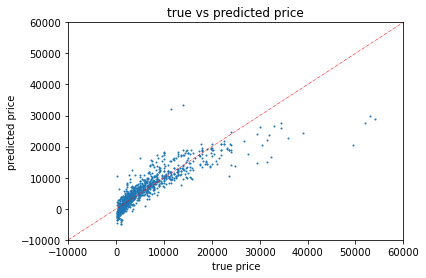

In [21]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=1000)

fig, ax = plt.subplots()
ax.scatter(train_y.loc[subsample_index], model.predict(LR_train_x.loc[subsample_index]),s=1)
ax.title.set_text('true vs predicted price')
ax.set_xlabel('true price')
ax.set_ylabel('predicted price')
ax.set_xlim(-10000,60000)
ax.set_ylim(-10000,60000)

line = matplotlib.lines.Line2D([-10000,60000], [-10000,60000], color='red', ls='-.',lw=0.5)
ax.add_line(line)

在預測結果良好時，散點圖的點應該盡可能分布在紅線上，由上圖可知，整體預測結果不是特別好。  
而需特別注意的是，有許多預測值位在<0部分，並不合理。  
以下就此問題進一步分析：

Text(0, 0.5, 'count')

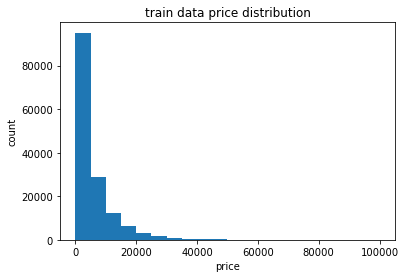

In [22]:
plt.hist(train_y,bins=20)
plt.title('train data price distribution')
plt.xlabel('price')
plt.ylabel('count')

由上圖可知，預測目標price嚴重右偏，和指數分布非常相似。  
因一般模型假設誤差服從正態分布，預測目標嚴重右偏的狀況會使的誤差同樣右偏，使的模型假設不成立，影響模型效果，故以下對price進行log變換以改善嚴重右偏的問題。

In [9]:
train_y_ln = np.log(train_y + 1)

Text(0, 0.5, 'count')

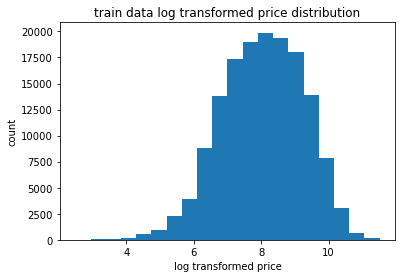

In [23]:
plt.hist(train_y_ln,bins=20)
plt.title('train data log transformed price distribution')
plt.xlabel('log transformed price')
plt.ylabel('count')

由上圖可知，經過log變換後，預測目標 ln(price+1) 較為接近正態分布。

#### 樹模型 (包含基本決策樹及集成學習)

In [10]:
from sklearn.tree import DecisionTreeRegressor #一般決策樹
from sklearn.ensemble import RandomForestRegressor #隨機森林
from sklearn.ensemble import GradientBoostingRegressor #GBDT
from xgboost.sklearn import XGBRegressor #XGBoost
from lightgbm.sklearn import LGBMRegressor #LightGBM

from datetime import datetime # 計算建模用時

In [25]:
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(n_estimators = 100, objective='reg:squarederror'),
    LGBMRegressor(n_estimators = 100)
    ]

In [26]:
result = dict()

for model in models:
    model_name = str(model).split('(')[0]
    print(model_name + ' training start...')
    start_time = datetime.now()
    try:
        scores = cross_val_score(model, X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
        result[model_name] = scores
        print(model_name + ' is finished, used '+str(datetime.now()-start_time))
    except:
        print(model_name + ' training failed')
    print('-----------------------------------------')

DecisionTreeRegressor training start...
DecisionTreeRegressor is finished, used 0:00:40.944145
-----------------------------------------
RandomForestRegressor training start...
RandomForestRegressor is finished, used 0:37:50.325307
-----------------------------------------
GradientBoostingRegressor training start...
GradientBoostingRegressor is finished, used 0:09:45.698431
-----------------------------------------
XGBRegressor training start...
XGBRegressor is finished, used 0:01:44.323268
-----------------------------------------
LGBMRegressor training start...
LGBMRegressor is finished, used 0:00:18.024440
-----------------------------------------


In [27]:
result = pd.DataFrame(result)
result.index = ['cv'+str(x) for x in range(1,6)]
result

,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor,LGBMRegressor
cv1,0.190553,0.138853,0.180537,0.147161,0.150818
cv2,0.194722,0.139051,0.180768,0.148731,0.152121
cv3,0.194185,0.140704,0.179177,0.149734,0.151943
cv4,0.192030,0.137845,0.176933,0.146592,0.149833
cv5,0.190932,0.139715,0.179941,0.148930,0.151466


由上面結果可知，隨機森林模型在所有fold中都表現最好，但訓練時間明顯比效果差異不大的XGBoost長很多。

## 二、調參

以下針對XGBoost模型進行Grid Search調參：(表現最好的RF訓練時間太長，先用XGBoost替代)

In [11]:
# 先檢視常用 XGBoost 參數組表現
common_params = {
                'objective':'reg:squarederror',
                'n_estimators': 500, 
                 'learning_rate': 0.1, 
                 'max_depth': 5, 
                 'min_child_weight': 1, 
                 'seed': 0, 
                 'subsample': 0.8, 
                 'colsample_bytree': 0.8, 
                 'gamma': 0, 
                 'reg_alpha': 0, 
                 'reg_lambda': 1
                }

In [149]:
print('XGB training with common parameters start...')
start_time = datetime.now()
scores = cross_val_score(XGBRegressor(**common_params), X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
print('training done, time used: '+str(datetime.now()-start_time))
print('result scores:')
print(scores)

XGB training with common parameters start...
training done, time used: 0:07:04.779507
result scores:
[0.14092171 0.14208014 0.14194219 0.13940248 0.140944  ]


由以上的score可以看出來，常用參數組表現比之前更好，接下來用Grid Search進一步嘗試優化：

In [150]:
from sklearn.model_selection import GridSearchCV

In [151]:
### 所有調參選擇
n_estimators = [100, 500, 600]
learning_rate = [0.01, 0.1, 0.2]
max_depth = [3, 5, 7]
min_child_weight = [1, 3, 5]
gamma = [0, 0.1, 0.5]
subsample = [0.7, 0.8, 0.9]
colsample_bytree = [0.7, 0.8, 0.9]
reg_alpha = [0, 0.05, 0.5, 1]
reg_lambda = [0, 0.5, 1, 2]

In [152]:
given_params_dict = common_params.copy()

search_params_dict = {
            'n_estimators': n_estimators, 
             'learning_rate': learning_rate, 
             'max_depth': max_depth, 
             'min_child_weight': min_child_weight, 
             'subsample': subsample, 
             'colsample_bytree': colsample_bytree, 
             'gamma': gamma, 
             'reg_alpha': reg_alpha, 
             'reg_lambda': reg_lambda
            }

若同時對所有參數進行Grid Search，計算量過大，每次1-2個參數更好。

In [163]:
def XGB_GS(given_params_dict, search_params_dict, search_params_keys, update_with_best=True):
    print('Grid Search for {} start...'.format(search_params_keys))
    start_time = datetime.now()
    
    given_params = given_params_dict.copy()
    searching_params = {}
    for sp in search_params_keys:
        searching_params.update({sp:search_params_dict[sp]})
        del given_params[sp]
        
    print('given_params:')
    print(given_params)
    print('searching_params:')
    print(searching_params)
    
    model = XGBRegressor(**given_params)

    xgb_clf = GridSearchCV(model, searching_params, cv=5)
    xgb_clf.fit(train_x, train_y_ln)
    print('Grid Search for {} finished, used time: {}'.format(str(search_params_keys),str(datetime.now()-start_time)))\
    
    print('get best parameters:')
    print(xgb_clf.best_params_)
    
    if update_with_best:
        given_params_dict.update(xgb_clf.best_params_)
        print('parameter updated')
        
    print('-------------------------------')

In [155]:
### 定義調參順序
search_plan = [
                  ['n_estimators'],
                  ['learning_rate'],
                  ['max_depth','min_child_weight'],
                  ['gamma'],
                  ['subsample'],
                  ['colsample_bytree'],
                  ['reg_alpha','reg_lambda']
              ]

In [164]:
### 依照上面定義順序自動調參
for search_params_keys in search_plan:
    XGB_GS(given_params_dict, search_params_dict, search_params_keys)

Grid Search for ['n_estimators'] start...
given_params:
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
searching_params:
{'n_estimators': [100, 500, 600]}
Grid Search for ['n_estimators'] finished, used time: 0:09:26.846454
get best parameters:
{'n_estimators': 600}
parameter updated
-------------------------------
Grid Search for ['learning_rate'] start...
given_params:
{'objective': 'reg:squarederror', 'n_estimators': 600, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
searching_params:
{'learning_rate': [0.01, 0.1, 0.2]}
Grid Search for ['learning_rate'] finished, used time: 0:13:52.744166
get best parameters:
{'learning_rate': 0.1}
parameter updated
-------------------------------
Grid Search for ['max_depth', 'min_child_weight'] start...
given_par

In [168]:
### 比較一般常用參數組和調參獲得的 best parameters 組合
print('common_params:')
print(common_params)
print('given_params_dict:')
print(given_params_dict)

common_params:
{'objective': 'reg:squarederror', 'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
given_params_dict:
{'objective': 'reg:squarederror', 'n_estimators': 600, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'seed': 0, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 1, 'reg_lambda': 2}


以獲得的best parameters再做一次訓練檢視效果：

In [169]:
print('XGB training with best parameters start...')
start_time = datetime.now()
scores = cross_val_score(XGBRegressor(**given_params_dict), X=train_x, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
print('training done, time used: '+str(datetime.now()-start_time))
print('result scores:')
print(scores)

XGB training with best parameters start...
training done, time used: 0:10:30.556643
result scores:
[0.13502122 0.13504383 0.13542813 0.13324043 0.13517419]


In [12]:
best_params_dict = {
        'objective': 'reg:squarederror', 
        'n_estimators': 600, 
        'learning_rate': 0.1, 
        'max_depth': 7, 
        'min_child_weight': 3, 
        'seed': 0, 
        'subsample': 0.9, 
        'colsample_bytree': 0.7, 
        'gamma': 0.1, 
        'reg_alpha': 1, 
        'reg_lambda': 2
}

上述結果顯示整體MAE降低約0.005，可見調參確實優化了，但是否有過擬合狀況需對測試集進行預測後比對才能確定。

## 三、測試集預測

以下用三個模型(隨機森林、常用參數組 XGBoost、調參後 XGBoost)對測試集進行預測，並將各自預測結果上傳，檢視結果。  
之所以還考慮常用參數組的 XGBoost 是因為不能確定調參後模型表現進度是否因為過擬合，故以兩模型做預測，由測試集結果來輔助判斷。

預測測試集的同時也需要檢視訓練集預測狀況，以幫助後續判斷模型是否過擬合，若訓練集預測準確度高但測試集低，則表示模型對訓練集數據過擬合。  
以下拆分訓練集：

In [13]:
from sklearn.model_selection import train_test_split
train_x_train, train_x_test, train_y_ln_train, train_y_ln_test = train_test_split(train_x,train_y_ln,test_size=0.2)
# 競賽目標的測試集 = test_x

In [14]:
# 將預測出來 log 變換後的 price 轉換回原本的 price
def reverse_log_price(series):
    return np.exp(series)+1

In [15]:
train_y_test = reverse_log_price(train_y_ln_test)

### 1. 隨機森林

In [17]:
print('Random Forest')
start_time = datetime.now()

RF = RandomForestRegressor()
RF.fit(train_x_train,train_y_ln_train)

RF_pred_train = RF.predict(train_x_test)
RF_pred_train_reversed = reverse_log_price(RF_pred_train)
MAE_RF_train = mean_absolute_error(train_y_test, RF_pred_train_reversed)
print('RandomForest, MAE for splited train data = '+str(np.round(MAE_RF_train,4)))

RF_pred_test = RF.predict(test_x)
RF_pred_test_reversed = reverse_log_price(RF_pred_test)

print('used time = '+str(datetime.now()-start_time))

Random Forest
RandomForest, MAE for splited train data = 647.0207
used time = 0:03:41.783076


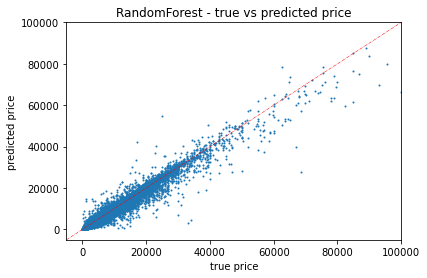

In [18]:
fig, ax = plt.subplots()
ax.scatter(train_y_test, RF_pred_train_reversed,s=1)
ax.title.set_text('RandomForest - true vs predicted price')
ax.set_xlabel('true price')
ax.set_ylabel('predicted price')
ax.set_xlim(-5000,100000)
ax.set_ylim(-5000,100000)

line = matplotlib.lines.Line2D([-5000,100000], [-5000,100000], color='red', ls='-.',lw=0.5)
ax.add_line(line)

### 2. 常用參數 XGBoost

In [19]:
print('XGBoost with common parameters')
start_time = datetime.now()

xgb_common = XGBRegressor(**common_params)
xgb_common.fit(train_x_train,train_y_ln_train)

xgb_common_pred_train = xgb_common.predict(train_x_test)
xgb_common_pred_train_reversed = reverse_log_price(xgb_common_pred_train)
MAE_xgb_common_train = mean_absolute_error(train_y_test, xgb_common_pred_train_reversed)
print('MAE for splited train data = '+str(np.round(MAE_xgb_common_train,4)))

xgb_common_pred_test = xgb_common.predict(test_x)
xgb_common_pred_test_reversed = reverse_log_price(xgb_common_pred_test)

print('used time = '+str(datetime.now()-start_time))

XGBoost with common parameters
MAE for splited train data = 665.9568
used time = 0:00:53.967701


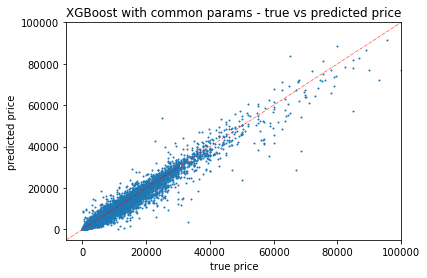

In [20]:
fig, ax = plt.subplots()
ax.scatter(train_y_test, xgb_common_pred_train_reversed,s=1)
ax.title.set_text('XGBoost with common params - true vs predicted price')
ax.set_xlabel('true price')
ax.set_ylabel('predicted price')
ax.set_xlim(-5000,100000)
ax.set_ylim(-5000,100000)

line = matplotlib.lines.Line2D([-5000,100000], [-5000,100000], color='red', ls='-.',lw=0.5)
ax.add_line(line)

### 3. Grid Search 參數 XGBoost

In [21]:
print('XGBoost with Grid Search best parameters')
start_time = datetime.now()

xgb_GS = XGBRegressor(**best_params_dict)
xgb_GS.fit(train_x_train,train_y_ln_train)

xgb_GS_pred_train = xgb_GS.predict(train_x_test)
xgb_GS_pred_train_reversed = reverse_log_price(xgb_GS_pred_train)
MAE_xgb_GS_train = mean_absolute_error(train_y_test, xgb_GS_pred_train_reversed)
print('MAE for splited train data = '+str(np.round(MAE_xgb_GS_train,4)))

xgb_GS_pred_test = xgb_GS.predict(test_x)
xgb_GS_pred_test_reversed = reverse_log_price(xgb_GS_pred_test)

print('used time = '+str(datetime.now()-start_time))

XGBoost with Grid Search best parameters
MAE for splited train data = 624.1711
used time = 0:01:17.205326


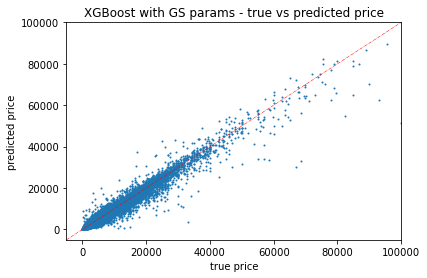

In [22]:
fig, ax = plt.subplots()
ax.scatter(train_y_test, xgb_GS_pred_train_reversed,s=1)
ax.title.set_text('XGBoost with GS params - true vs predicted price')
ax.set_xlabel('true price')
ax.set_ylabel('predicted price')
ax.set_xlim(-5000,100000)
ax.set_ylim(-5000,100000)

line = matplotlib.lines.Line2D([-5000,100000], [-5000,100000], color='red', ls='-.',lw=0.5)
ax.add_line(line)

以上得到三個模型在訓練集的 MAE 分別為 647.02(RF)、665.96(XGB_common)、624.17(XGB_GS)。  
且從預測值和真實值的散點圖來看，相比先前price未做log轉換的線性回歸，整體點分布更集中在紅線附近，也就是預測更為準確。  

接著需將預測結果轉為競賽要求的格式再行上傳，競賽要求格式如下：

In [69]:
submit_sample = pd.read_csv('./raw_data/used_car_sample_submit.csv')
submit_sample.head()

,SaleID,price
0,150000,0
1,150001,0
2,150002,0
3,150003,0
4,150004,0


目前模型預測結果格式如下：

In [23]:
RF_pred_test_reversed

array([31927.97174968,   352.26728757,  6433.3270456 , ...,
        7763.92209872,  9203.01979868,  3391.19986377])

用下面函數將預測結果轉為競賽要求格式：

In [24]:
def transform_pred_to_submit(pred_price_array, SaleID_Series):
    pred_price = pd.Series(pred_price_array)
    df = pd.concat([SaleID_Series, pred_price],axis=1,ignore_index=True)
    df.columns=['SaleID','price']
    return df

In [25]:
SaleID_Series_test = pd.Series(list(test_x.index))

In [26]:
RF_submit = transform_pred_to_submit(RF_pred_test_reversed, SaleID_Series_test)
RF_submit.head()

,SaleID,price
0,150000,31927.971750
1,150001,352.267288
2,150002,6433.327046
3,150003,11768.682098
4,150004,617.961450


由上面切片結果可見格式已轉為競賽要求。  
接著儲存結果並對另外兩個模型結果做同樣轉換：

In [30]:
RF_submit.to_csv('./submits/RF_submit_1.csv',index=False)

xgb_common_submit = transform_pred_to_submit(xgb_common_pred_test_reversed, SaleID_Series_test)
xgb_common_submit.to_csv('./submits/xgb_common_submit_1.csv',index=False)

xgb_GS_submit = transform_pred_to_submit(xgb_GS_pred_test_reversed, SaleID_Series_test)
xgb_GS_submit.to_csv('./submits/xgb_GS_submit_1.csv',index=False)

儲存訓練集拆分出的測試集的預測結果，作後續模型融合用：

In [31]:
SaleID_Series_train = pd.Series(list(train_x_test.index))

RF_train_pred = transform_pred_to_submit(RF_pred_train_reversed, SaleID_Series_train)
RF_train_pred.to_csv('./pred_result/RF_train_pred_1.csv',index=False)

xgb_common_train_pred = transform_pred_to_submit(xgb_common_pred_train_reversed, SaleID_Series_train)
xgb_common_train_pred.to_csv('./pred_result/xgb_common_train_pred_1.csv',index=False)

xgb_GS_train_pred = transform_pred_to_submit(xgb_GS_pred_train_reversed, SaleID_Series_train)
xgb_GS_train_pred.to_csv('./pred_result/xgb_GS_train_pred_1.csv',index=False)

同時也儲存訓練集拆分出的測試集的price真實值，方便模型融合後結果檢視：

In [38]:
pd.DataFrame(train_y_test).to_csv('./pred_result/train_y_test_1.csv')

### 測試集 MAE 結果

||隨機森林|XGB_common|XGB_GS|
|---|---|---|---|
|訓練集 MAE|647.02|665.96|624.17|
|測試集 MAE|630.31||613.27|

由上面結果可知，測試集和訓練集MAE差異並不顯著，推測沒有過擬合問題。